In [40]:
#Imports

# +------------+
#  SUUUUUUUUUUU
# +------------+

#Imports
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import _california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.ensemble import *

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#Settings
plt.style.use('dark_background')

#Colonnes du dataset
"""
- MedInc        median income in block group
- HouseAge      median house age in block group
- AveRooms      average number of rooms per household
- AveBedrms     average number of bedrooms per household
- Population    block group population
- AveOccup      average number of household members
- Latitude      block group latitude
- Longitude     block group longitude
- MedHouseVal   median house value
"""

#Creation du dataframe avec le dataset
df = _california_housing.fetch_california_housing(as_frame=True).frame


In [45]:
#Variables

#Definition de la target
target_name = "MedHouseVal"
target = df[target_name]

#Colonnes exclues pour le test
columns_to_drop = [
    target_name, 
    # "Population", 
    # "AveOccup", 
    # "AveBedrms", 
    # "HouseAge", 
    # "AveRooms"
]
data = df.drop(columns=columns_to_drop)

#Modeles a tester
models = [
    AdaBoostRegressor(),  
    BaggingRegressor(n_jobs=-1), 
    ExtraTreesRegressor(n_jobs=-1), 
    GradientBoostingRegressor(), 
    RandomForestRegressor(n_jobs=-1), 
    HistGradientBoostingRegressor()
]

linear_models = [
    LinearRegression(),
    Ridge(),
    RidgeCV(),
    SGDRegressor(),
    Lasso(),
]

models_boost = [
    #AdaBoostRegressor(base_estimator=BaggingRegressor(n_jobs=-1)),
    #AdaBoostRegressor(base_estimator=ExtraTreesRegressor(n_jobs=-1)),
    #AdaBoostRegressor(base_estimator=GradientBoostingRegressor()),
    #AdaBoostRegressor(base_estimator=RandomForestRegressor(n_jobs=-1)),
    AdaBoostRegressor(random_state=69, learning_rate=1,n_estimators=100, base_estimator=HistGradientBoostingRegressor(learning_rate=0.1, max_iter=1000, max_depth=8, warm_start=True, max_leaf_nodes=None, max_bins=255)),

    #BaggingRegressor(base_estimator=BaggingRegressor(n_jobs=-1)),
    #BaggingRegressor(base_estimator=ExtraTreesRegressor(n_jobs=-1)),
    #BaggingRegressor(base_estimator=GradientBoostingRegressor()),
    #BaggingRegressor(base_estimator=RandomForestRegressor(n_jobs=-1)),
    #BaggingRegressor(base_estimator=HistGradientBoostingRegressor()),
]

#Nombre de training par modele
attemps = 1

## Fonctions

In [46]:
#Traitement des donnees

def TestModel(models):
    global attemps
    
    #Initialisation de la dataframe des resultats
    result_df = pd.DataFrame(columns=["ModelName","AvgScore","MaxScore","AvgExecTime"])

    for model in models:

        #Affichage
        model_name = model.__class__.__name__
        print(f"{model_name}")

        #Initialisation des listes
        score_results = []
        time_results = []
        
        for i in tqdm(range(attemps)):

            #Demarrage du timer
            start = time.time()

            #Split et Fit
            data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.20, random_state=44)
            model.fit(data_train, target_train)

            #Calcul du score
            score = model.score(data_test, target_test)

            #Sauvegarde des resultats dans les listes
            score_results.append(score)
            time_results.append(time.time() - start)

        #Calcul des stats
        avg_score = round(np.average(score_results) * 100, 3)
        max_score = round(np.max(score_results) * 100, 3)
        avg_time = round(np.average(time_results), 3)

        #Sauvegarde des resultats dans la dataframe
        new_row = pd.DataFrame([[model_name, avg_score, max_score, avg_time]], columns=["ModelName","AvgScore","MaxScore","AvgExecTime"])
        result_df = pd.concat([result_df, new_row])

    #Affichage
    print(f"-"*62, "\nResults :")
    print(result_df.to_string(index=False))
    print(f"-"*62)

In [47]:
#Learning Curve (Subplots MatPlotLib)

def subplots_learnings_curves(
    models,
    data,
    target
):
    plt.figure(1)
    n_jobs = -1
    fig, graphs = plt.subplots(1, len(models), figsize=(5* len(models), 5))
    points_amount = 50
    train_score_arr = []
    test_scores_arr = []

    for i in tqdm(range(len(models))):
        graphs[i].set_title(models[i].__class__.__name__)
        graphs[i].set_xlabel("Training examples")
        graphs[i].set_ylabel("Score")
        
        train_sizes, train_scores, test_scores = learning_curve(
        estimator = models[i],
        X=data,
        y=target,
        n_jobs=n_jobs,
        train_sizes=np.linspace(0.1, 1, points_amount)
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        train_score_arr.append(train_scores_mean)
        test_scores_arr.append(test_scores_mean)

    

    for i in range(len(train_score_arr)):
        graphs[i].set_ylim(np.min(test_scores_arr),1.2)
        graphs[i].plot(train_sizes, train_score_arr[i])
        graphs[i].plot(train_sizes, test_scores_arr[i])
        graphs[i].legend(labels=["train", "test"], loc="lower right")

    return plt

## Calls

In [48]:
#Call Traitement des donnees

#TestModel(models)
#TestModel(linear_models)
TestModel(models_boost)

AdaBoostRegressor


100%|██████████| 1/1 [12:06<00:00, 726.90s/it]

-------------------------------------------------------------- 
Results :
        ModelName  AvgScore  MaxScore  AvgExecTime
AdaBoostRegressor     87.11     87.11      726.897
--------------------------------------------------------------


100%|██████████| 2/2 [02:31<00:00, 75.85s/it]


<Figure size 640x480 with 0 Axes>

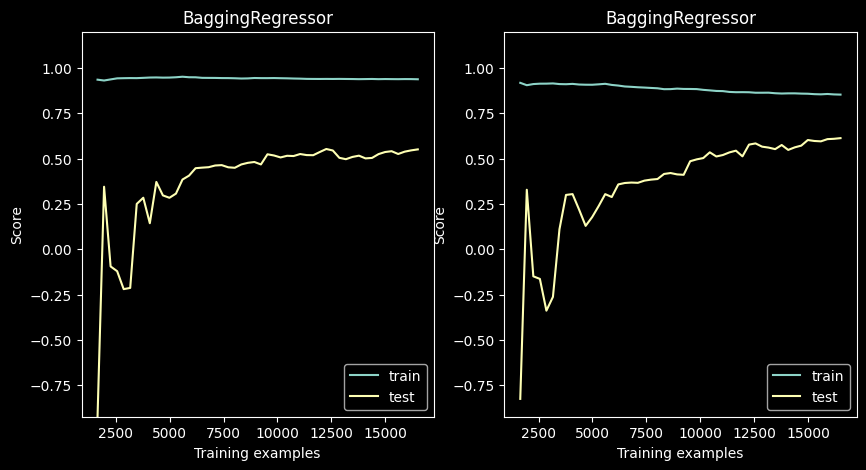

In [30]:
#Call Learning Curve (Subplots MatPlotLib)

subplots_learnings_curves(
    models_boost, 
    data,
    target
)

plt.show()